Data shape: (58075, 41)

First few rows:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   

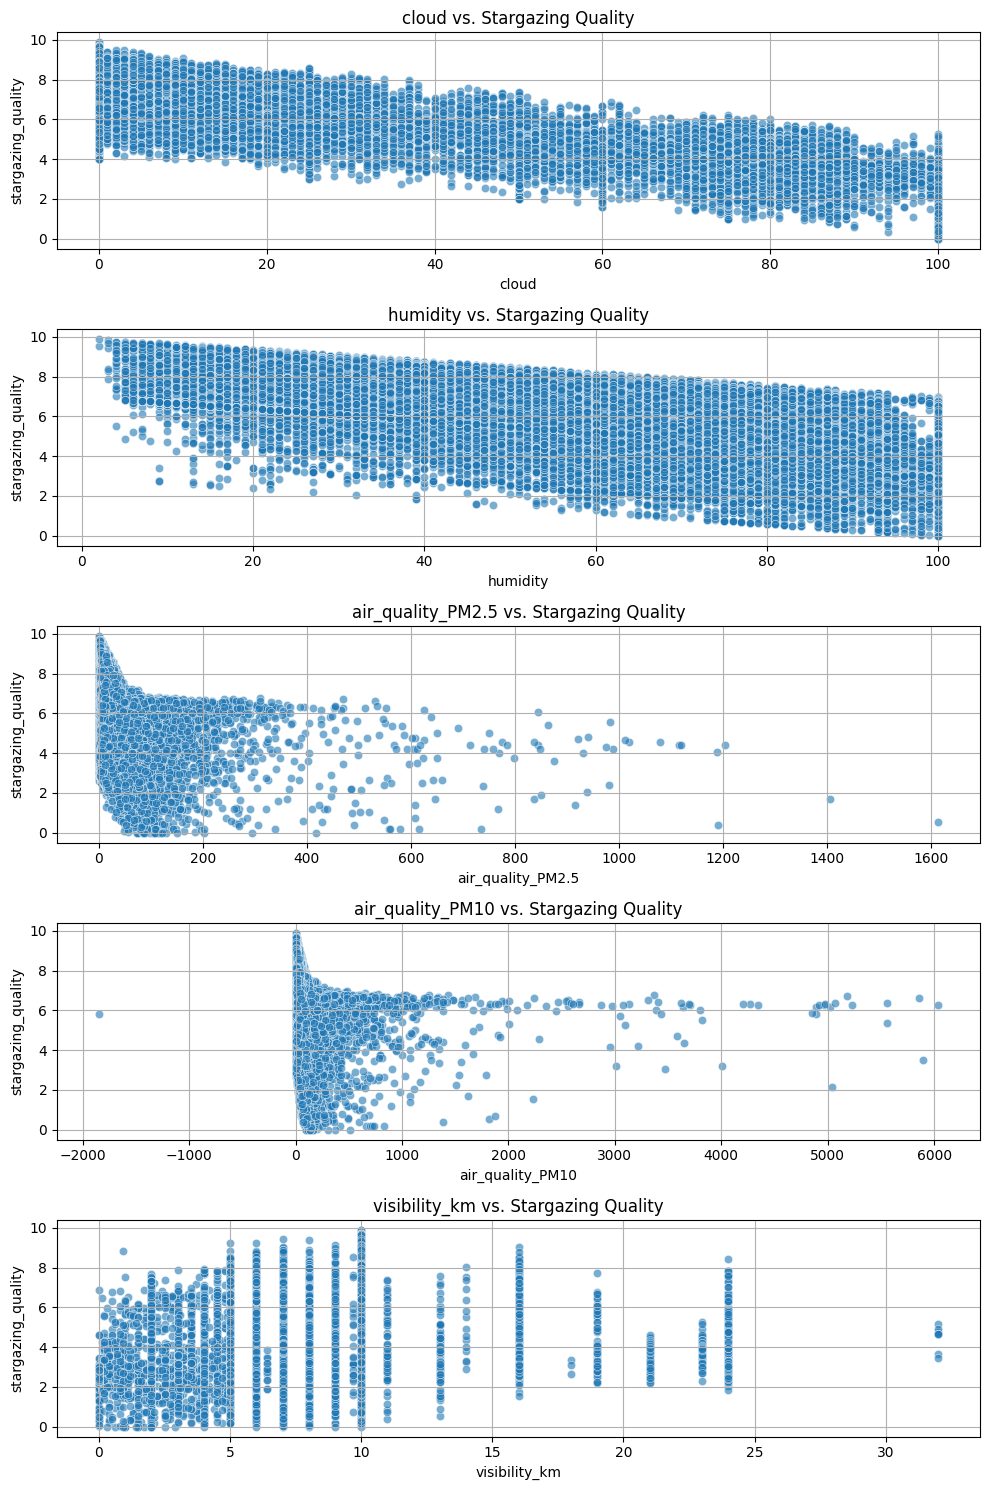

Training set: 43556 samples
Test set: 14519 samples
Linear Regression - MSE: 0.4744, R²: 0.8600
Decision Tree - MSE: 0.0119, R²: 0.9965
Random Forest - MSE: 0.0028, R²: 0.9992


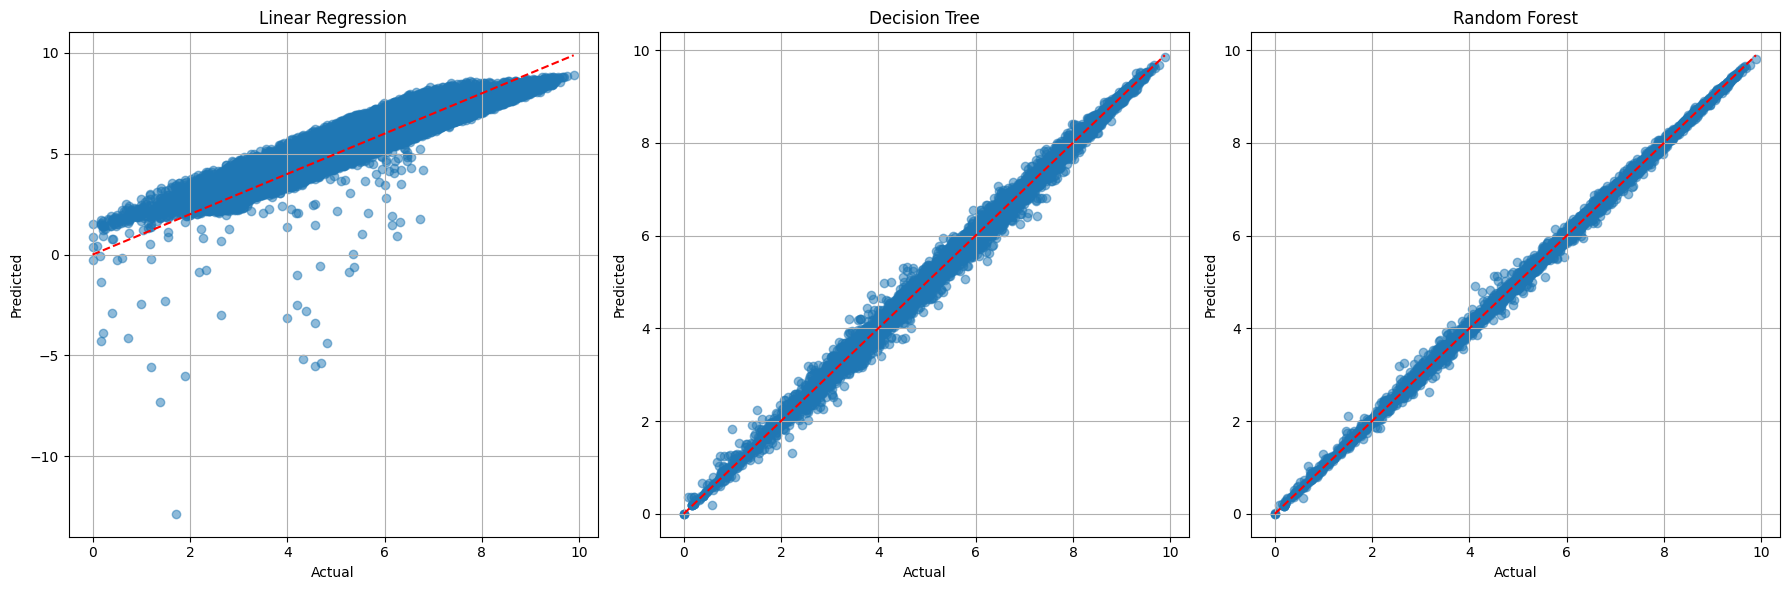


Best model: random_forest
MSE: 0.0028

Feature Importance:
             Feature  Importance
2              cloud    0.679771
4  air_quality_PM2.5    0.171338
3           humidity    0.128990
5   air_quality_PM10    0.019248
1          longitude    0.000224
0           latitude    0.000212
7           uv_index    0.000175
6      visibility_km    0.000042


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load Weather Data
weather_file_path = r'C:\Users\user\Desktop\stargazing_summative\linear_regression\GlobalWeatherRepository.csv'
weather_data = pd.read_csv(weather_file_path)

print(f"Data shape: {weather_data.shape}")
print("\nFirst few rows:")
print(weather_data.head())

# Data Preparation and Feature Engineering
# Check for missing values
print("Missing values per column:")
print(weather_data.isnull().sum())

# Fill missing values
weather_data_clean = weather_data.fillna({
    'cloud': weather_data['cloud'].mean(),
    'humidity': weather_data['humidity'].mean(),
    'air_quality_PM2.5': weather_data['air_quality_PM2.5'].mean(),
    'air_quality_PM10': weather_data['air_quality_PM10'].mean(),
    'visibility_km': weather_data['visibility_km'].mean(),
    'uv_index': weather_data['uv_index'].mean()
})

# Create stargazing quality score (0-10 scale, higher is better)
weather_data_clean['stargazing_quality'] = (
    (100 - weather_data_clean['cloud']) * 0.4 +
    (100 - weather_data_clean['humidity']) * 0.3 +
    (100 - np.clip(weather_data_clean['air_quality_PM2.5'] * 2, 0, 100)) * 0.15 +
    (100 - np.clip(weather_data_clean['air_quality_PM10'], 0, 100)) * 0.15
) / 100 * 10

print("\nStargazing quality stats:")
print(weather_data_clean['stargazing_quality'].describe())

# Visualization of Quality Score vs. Features
# Visualize relationships between features and stargazing quality
features = ['cloud', 'humidity', 'air_quality_PM2.5', 'air_quality_PM10', 'visibility_km']

fig, axes = plt.subplots(len(features), 1, figsize=(10, 15))
for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='stargazing_quality', data=weather_data_clean, alpha=0.6, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Stargazing Quality')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

# Model Training and Comparison
# Select features and target
features = ['latitude', 'longitude', 'cloud', 'humidity', 'air_quality_PM2.5', 
            'air_quality_PM10', 'visibility_km', 'uv_index']
X = weather_data_clean[features]
y = weather_data_clean['stargazing_quality']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)
print(f"Linear Regression - MSE: {lr_mse:.4f}, R²: {lr_r2:.4f}")

# Model 2: Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)  # Trees don't need scaling
dt_preds = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)
print(f"Decision Tree - MSE: {dt_mse:.4f}, R²: {dt_r2:.4f}")

# Model 3: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Trees don't need scaling
rf_preds = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")

# Compare model predictions visually
results = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': lr_preds,
    'Decision Tree': dt_preds,
    'Random Forest': rf_preds
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, model_name in enumerate(['Linear Regression', 'Decision Tree', 'Random Forest']):
    axes[i].scatter(results['Actual'], results[model_name], alpha=0.5)
    axes[i].plot([results['Actual'].min(), results['Actual'].max()], 
                 [results['Actual'].min(), results['Actual'].max()], 'r--')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{model_name}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Select and Save Best Model
# Find best model based on MSE
models = {
    'linear_regression': (lr_model, lr_mse, scaler),
    'decision_tree': (dt_model, dt_mse, None),
    'random_forest': (rf_model, rf_mse, None)
}

best_model_name = min(models, key=lambda k: models[k][1])
best_model, best_mse, best_scaler = models[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"MSE: {best_mse:.4f}")

# Feature importance (if applicable)
if best_model_name != 'linear_regression':
    importances = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\nFeature Importance:")
    print(importances)
else:
    coefficients = pd.DataFrame({
        'Feature': features,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', ascending=False)
    print("\nModel Coefficients:")
    print(coefficients)

# Save the best model and scaler
# joblib.dump(best_model, "stargazing_model.pkl")
# print(f"Model saved as 'stargazing_model.pkl'")

# if best_scaler is not None:
#     joblib.dump(best_scaler, "scaler.pkl")
#     print("Scaler saved as 'scaler.pkl'")

# Save features list for reference
# with open('model_features.txt', 'w') as f:
#     f.write(','.join(features))